# Problem 2

*From a large population-based case–control study on Oral cancer conducted in the US (Day et al., 1993), the data related to the African American population (194 cases, here ccstatus = 1, and 203 controls, here ccstatus = 0) has been selected. The aim of the study is to evaluate the risk of Oral cancer based on the variables drinks (number of 1oz ethanol-equivalent drinks consumed per week), sex, age and cigs (number of cigarettes smoked per day).*

*The original dataset has been again arbitrarily split into a training (199 observations, train = TRUE) and a test (198, train = FALSE) set.*

## Setup

In [2]:
# install.packages("e1071")
# install.packages("LiblineaR")
# install.packages("ada")
library(class)
library(caret)

MisclassificationRate = function(models, data) {
    InnerFunction = function(model) {
        predictions = predict(model, data)
        truth = `$`(data, 'ccstatus')
        misclassification.rate = mean(predictions != truth)
        return(misclassification.rate)
    }
    return(as.numeric(lapply(models, InnerFunction)))
}

Loading required package: lattice
Loading required package: ggplot2


## Load data

In [3]:
load("oralcancer.rdata")

# ccstatus is a categorical
data$ccstatus = as.factor(data$ccstatus)

training.data = data[data$train == TRUE, ]
training.data = AllColumnsExcept(training.data, 'train')

test.data = data[data$train == FALSE, ]
test.data = AllColumnsExcept(test.data, 'train')

## 2.1 kNN

In [3]:
Ks = seq(1, 151, 10)

In [4]:
kNN = function(data, method = 'none', number = NULL, K = Ks) {
    model = train(
        ccstatus ~ .,
        data = training.data,
        method = "knn",
        preProcess = c("center", "scale"),
        tuneGrid = expand.grid(k = K),
        metric = 'Accuracy',
        trControl = trainControl(
            method = method,
            number = number
        )
    )
    model$misclassification.rate = 1 - model$results$Accuracy
    return(model)
}

*Use the k-nearest-neighbour algorithm to classify cases and controls.*

In [5]:
knn.models = lapply(Ks, (function (k) kNN(training.data, K = k)))

*Draw in the same plot the training and test error and write your considerations.*

In [6]:
knn.models.training.misclassification.rate = MisclassificationRate(knn.models, training.data)
knn.models.test.misclassification.rate = MisclassificationRate(knn.models, test.data)

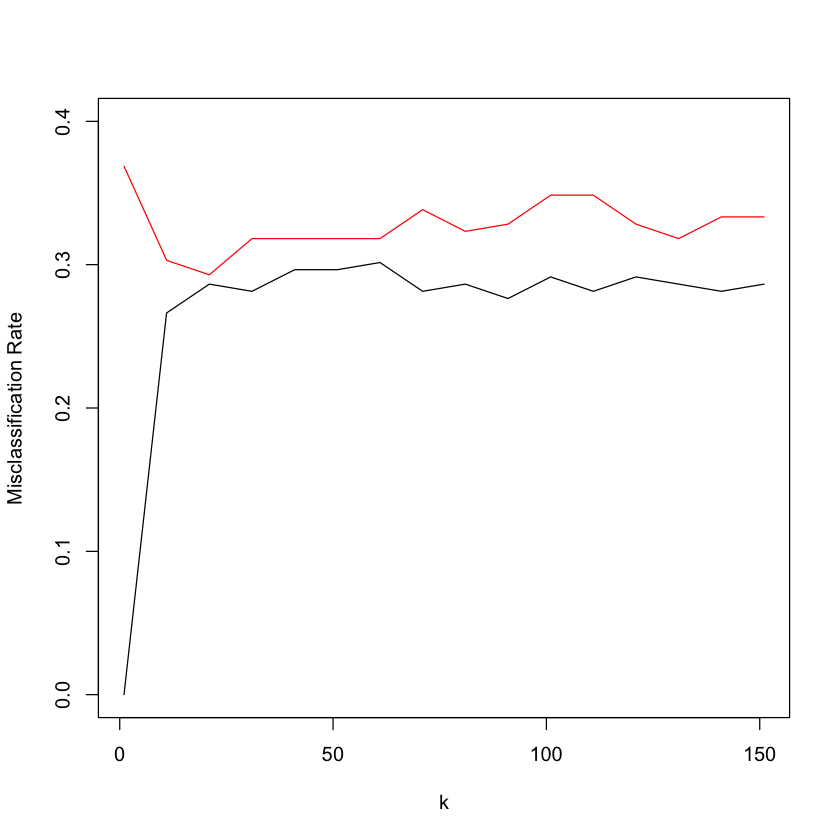

In [7]:
plot(x = Ks, y = knn.models.training.misclassification.rate, type = 'l', col = 1, xlab = 'k', ylab = 'Misclassification Rate', ylim = c(0.0, 0.4))
lines(x = Ks, y = knn.models.test.misclassification.rate, type = 'l', col = 2)

## 2.2 kNN Model selection

*Back to the k-nearest-neighbour, select the optimal value of k via 5-, 10- and LOO-cross validation.*

In [8]:
knn.cv5.model = kNN(training.data, 'cv', 5)
knn.cv5.model$bestTune

,k
5,41


In [9]:
knn.cv10.model = kNN(training.data, 'cv', 10)
knn.cv10.model$bestTune

,k
15,141


In [10]:
knn.loo.model = kNN(training.data, 'loocv')
knn.loo.model$bestTune

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

,k
15,141


*Are the results similar to the previous ones?*

*Plot k versus the prediction error estimates.*

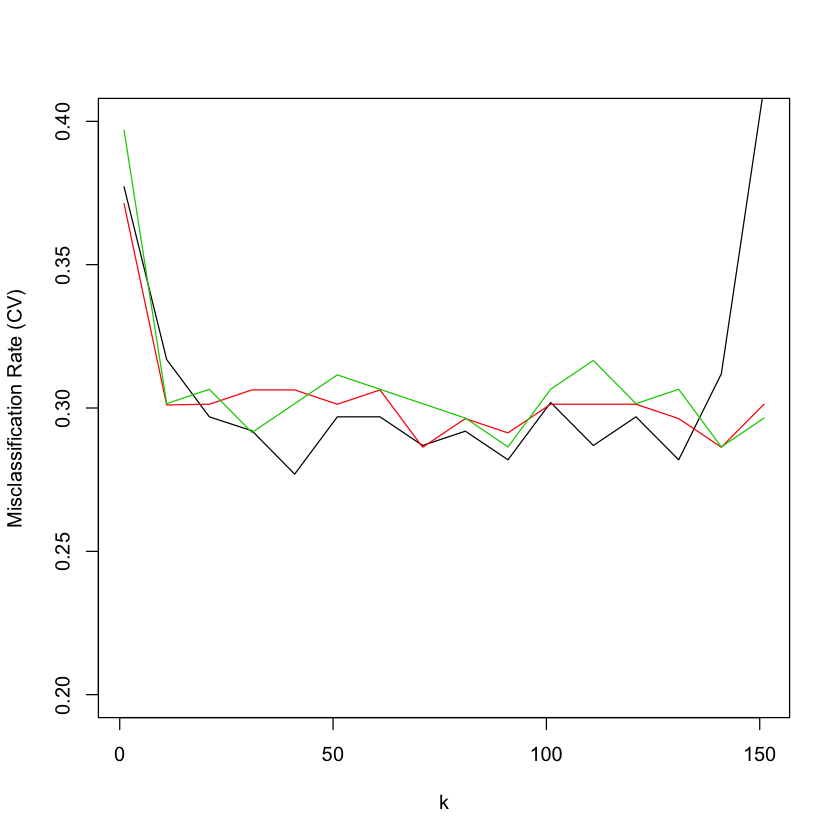

In [11]:
plot(x = Ks, y = knn.cv5.model$misclassification.rate, type = 'l', col = 1, xlab = 'k', ylab = 'Misclassification Rate (CV)', ylim = c(0.2, 0.4))
lines(x = Ks, y = knn.cv10.model$misclassification.rate, type = 'l', col = 2)
lines(x = Ks, y = knn.loo.model$misclassification.rate, type = 'l', col = 3)

*Do the three cross-validation procedures provide similar results?*

*Repeat the selection by using a simple bootstrap procedure and the .632 bootstrap procedure and plot the results as well.*

In [12]:
knn.boot.model = kNN(training.data, 'boot', 100)
knn.boot.model$bestTune

,k
9,81


In [13]:
knn.boot632.model = kNN(training.data, 'boot632', 100)
knn.boot632.model$bestTune

k
1


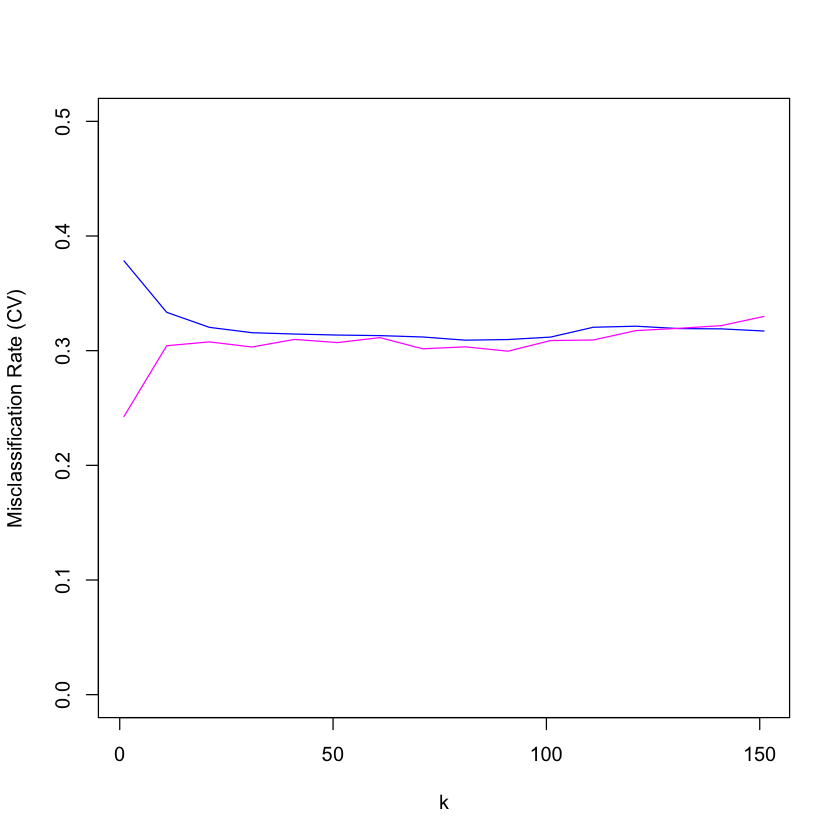

In [14]:
plot(x = Ks, y = knn.boot.model$misclassification.rate, type = 'l', col = 4, xlab = 'k', ylab = 'Misclassification Rate (CV)', ylim = c(0.0, 0.5))
lines(x = Ks, y = knn.boot632.model$misclassification.rate, type = 'l', col = 6)

*Are the results similar to the previous ones?*

## 2.3 Discriminant Analysis

*Use LDA and QDA to classify cases and controls.*

In [15]:
DiscriminantAnalysis = function(data, method) {
    model = train(
        ccstatus ~ .,
        data = data,
        method = method,
        trControl = trainControl(
            method = 'none'
        )
    )
    return(model)
}

In [16]:
lda.model = DiscriminantAnalysis(training.data, 'lda')
MisclassificationRate(list(lda.model), training.data)
MisclassificationRate(list(lda.model), test.data)

[1] 0.2512563

[1] 0.2979798

In [17]:
qda.model = DiscriminantAnalysis(training.data, 'qda')
MisclassificationRate(list(qda.model), training.data)
MisclassificationRate(list(qda.model), test.data)

[1] 0.2763819

[1] 0.3232323

*Which of the two algorithms should be preferred in this case?*

The LDA model performs better on the test set.

## 3.4 Logistic regression

*Repeat the analyses by using logistic regression, penalized versions of it based on L1 and L2 penalties, and L2Boost. Report the regression coefficients and compute training and test errors.*

### Logistic regression

In [122]:
logistic.model = train(
    ccstatus ~ .,
    data = training.data,
    family = "binomial",
    method = "glm"
)

In [135]:
coef(logistic.model$finalModel)
MisclassificationRate(list(logistic.model), training.data)
MisclassificationRate(list(logistic.model), test.data)

(Intercept)      drinks        cigs         age         sex 
-1.04364107  0.03514214  0.03964346 -0.01216435  0.65140495

[1] 0.2562814

[1] 0.3080808

### L1 penalty

In [160]:
PenalizedLogisticRegression = function(data, alpha) {
    model = train(
        ccstatus ~ .,
        data = data,
        method = "glmnet",
        family = "binomial",
        trControl = trainControl(
            method = 'cv',
            number = 10
        ),
        tuneGrid = expand.grid(
            alpha = alpha,
            lambda = seq(0, 1, 0.01)
        )
    )
    return(model)
}

In [161]:
logistic.l1.model = PenalizedLogisticRegression(training.data, alpha = 1)

In [162]:
logistic.l1.model$bestTune['lambda']
as.matrix(coef(logistic.l1.model$finalModel, logistic.l1.model$bestTune$lambda))
MisclassificationRate(list(logistic.l1.model), training.data)
MisclassificationRate(list(logistic.l1.model), test.data)

,lambda
9,0.08


,1
(Intercept),-0.70694033
drinks,0.01658807
cigs,0.01319844
age,0.00000000
sex,0.00000000


[1] 0.2613065

[1] 0.2979798

### L2 penalty

In [163]:
logistic.l2.model = PenalizedLogisticRegression(training.data, alpha = 0)

In [164]:
logistic.l1.model$bestTune['lambda']
as.matrix(coef(logistic.l2.model$finalModel, logistic.l2.model$bestTune$lambda))
MisclassificationRate(list(logistic.l2.model), training.data)
MisclassificationRate(list(logistic.l2.model), test.data)

,lambda
9,0.08


,1
(Intercept),-0.86161609
drinks,0.02680042
cigs,0.03647262
age,-0.01009634
sex,0.41876853


[1] 0.2663317

[1] 0.3030303

### L2Boost

In [167]:
l2boost.model = train(
    ccstatus ~ .,
    data = training.data,
    # TODO: Why center data?
    preProc = c("center"),
    # Uses mboost under the hood
    method = "glmboost",
    family = Binomial(link = "logit"),
    tuneGrid = expand.grid(
        mstop = c(100, 5000, 100),
        prune = 'no'
    ),
    trControl = trainControl(
        method = 'cv',
        number = 10
    )
)

In [166]:
l2boost.model$bestTune
as.matrix(coef(l2boost.model$finalModel))
MisclassificationRate(list(l2boost.model), training.data)
MisclassificationRate(list(l2boost.model), test.data)

,mstop,prune
2,5000,no



NOTE: Coefficients from a Binomial model are half the size of coefficients
 from a model fitted via glm(... , family = 'binomial').
See Warning section in ?coef.mboost



(Intercept),0.094210522
drinks,0.017571068
cigs,0.019821730
age,-0.006082177
sex,0.325702476


[1] 0.2562814

[1] 0.3080808

## AdaBoost

*Implement the algorithm AdaBoost with a tree as a classifier and plot train and test errors as a function of the number of boosting steps (iterations).*

In [8]:
ada.model = train(
    ccstatus ~ .,
    data = training.data,
    method = 'ada',
    trControl = trainControl(
        method = 'cv',
        number = 10
    ),
    tuneGrid = expand.grid(
        nu = 0.1,
        maxdepth = c(10, 20),
        iter = c(50, 100)
    )
)

In [9]:
ada.model$results
ada.model$bestTune

,nu,maxdepth,iter,Accuracy,Kappa,AccuracySD,KappaSD
1,0.1,10,50,0.7089474,0.4182418,0.09261928,0.1855767
3,0.1,20,50,0.6739474,0.3482418,0.08414151,0.1688152
2,0.1,10,100,0.6986842,0.3975138,0.08422195,0.1685177
4,0.1,20,100,0.7042105,0.4085083,0.10541801,0.2109630


iter,maxdepth,nu
50,10,0.1


*Would have AdaBoost profited by an early stop in this specific case?*

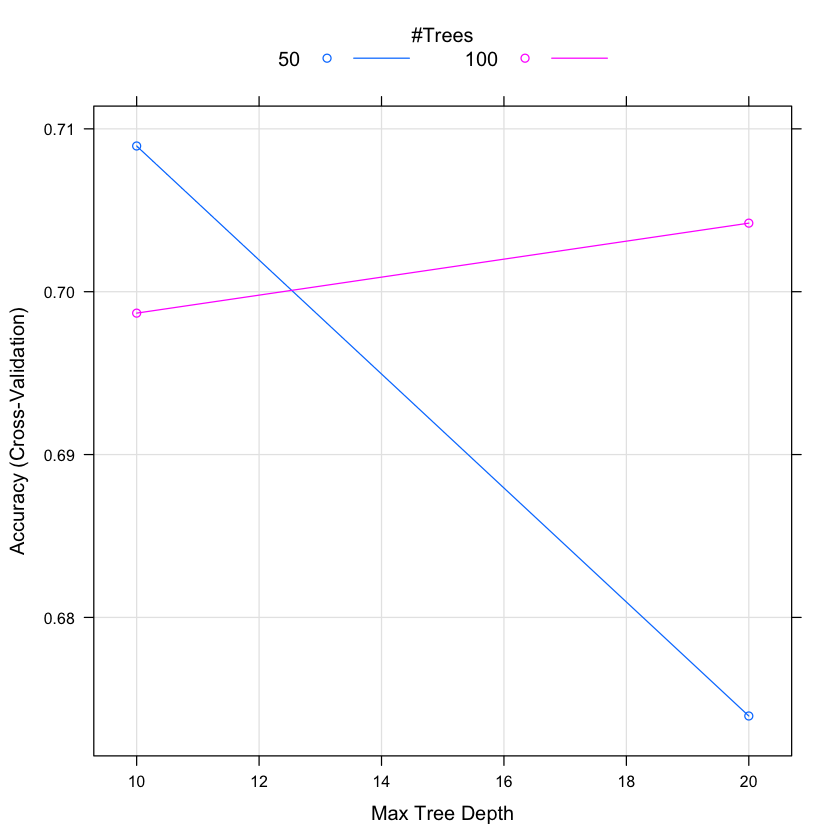

In [10]:
plot(ada.model)